In [1]:
#importing necessary libraries
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod
from collections import defaultdict
from shapely.ops import unary_union

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
censusTracts.shape

(869, 63)

In [4]:
branchInfo.loc[branchInfo['BRANCH'] == 'Roosevelt']

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
60,Roosevelt,,1101 W. Taylor Street,Chicago,IL,60607,,,"(41.86943838326072, -87.6544586134924)",1,None


In [5]:
branchInfo = branchInfo.drop([60,60])
branchInfo = branchInfo.set_index('BRANCH')
branchInfo = branchInfo.reset_index()
branchInfo

,BRANCH,HOURS OF OPERATION,ADDRESS,CITY,STATE,ZIP,PHONE,WEBSITE,LOCATION,PERMANENTLY_CLOSED,geometry
0,Albany Park,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",3401 W. Foster Ave.,Chicago,IL,60625,(773) 539-5450,https://www.chipublib.org/locations/3/,"(41.97557881655979, -87.71361314512697)",0,None
1,Altgeld,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",955 E. 131st Street,Chicago,IL,60827,(312) 747-3270,https://www.chipublib.org/locations/4/,"(41.65719847558056, -87.59883829075173)",0,None
2,Archer Heights,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5055 S. Archer Ave.,Chicago,IL,60632,(312) 747-9241,https://www.chipublib.org/locations/5/,"(41.80110836194246, -87.72648385568911)",0,None
3,Austin,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",5615 W. Race Ave.,Chicago,IL,60644,(312) 746-5038,https://www.chipublib.org/locations/6/,"(41.88917312206642, -87.7658203582574)",0,None
4,Austin-Irving,"Mon. & Wed., Noon-8; Tues. & Thurs., 10-6; Fri...",6100 W. Irving Park Rd.,Chicago,IL,60634,(312) 744-6222,https://www.chipublib.org/locations/7/,"(41.95312267684315, -87.77928489355646)",0,None
...,...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"Mon. & Wed., Noon-8; Tue. & Thu., 10-6; Fri. &...",830 W. 119th St.,Chicago,IL,60643,(312) 747-1425,https://www.chipublib.org/locations/78/,"(41.67790647382097, -87.6431683153105)",0,None
77,West Town,"Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",1625 W. Chicago Ave.,Chicago,IL,60622,(312) 743-0450,https://www.chipublib.org/locations/79/,"(41.89594730478282, -87.66829305460979)",0,None
78,"Whitney M. Young, Jr.","Mon. & Wed., 10-6; Tues. & Thurs., Noon-8; Fri...",415 East 79th St.,Chicago,IL,60619,(312) 747-0039,https://www.chipublib.org/locations/80/,"(41.7510184591363, -87.61495065361933)",0,None
79,Woodson Regional Library,"Mon. - Thurs., 9-8; Fri. & Sat., 9-5; Sun., 1-5",9525 S. Halsted St.,Chicago,IL,60628,(312) 747-6900,https://www.chipublib.org/locations/81/,"(41.720694885749005, -87.64304817213312)",0,None


In [6]:
branchCopy = branchInfo

In [7]:
branchCopy[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchCopy['LOCATION']]
branchCopy = branchCopy.drop(columns='LOCATION')


In [8]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [9]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [10]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [11]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary, key, iso_dict, branchname):
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            iso_dict[df.loc[i, key]] = overlapPolygon
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            dictionary[df.loc[i, key]] = propOverlap
            
            
            if len(df.loc[i, 'polygons in census']) > 0:
                hold = (df.loc[i, 'polygons in census'][0]).copy()
                c = len(hold.items())
                hold[c] = overlapPolygon
                df.loc[i, 'polygons in census']= [hold]
                
                hold = (df.loc[i, 'area coverage of each polygon in census'][0]).copy()
                c = len(hold.items())
                hold[branchname] = propOverlap
                df.loc[i, 'area coverage of each polygon in census']= [hold]
 
 
            else:
                first = {0:overlapPolygon}
                df.loc[i, 'polygons in census'] = [first]
                
                first = {branchname:propOverlap}
                df.loc[i, 'area coverage of each polygon in census'] = [first]
            
    return dictionary


In [12]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [13]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf, idf, scoreString, dictString, cgs, igs, lat, lon, key, travelTime):
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    cdf['polygons in census'] = np.empty((len(cdf), 0)).tolist()
    cdf['area coverage of each polygon in census'] = np.empty((len(cdf), 0)).tolist()
    idf['number of census tracts reached'] = 0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas

    
   
    for i in range(len(idf)):
        # Create a new dictionary for tracking isochrones
        iso_dict = defaultdict(list)
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs], cdf, cgs, dictionary, key, iso_dict, idf.loc[i,'BRANCH'])
        idf.loc[i,dictString] = [dictionary]
        idf.loc[i,'iso geometries'] = [iso_dict]
        idf.loc[i, 'number of census tracts reached'] = len(dictionary.items())
        
        for j in range(len(cdf)):
             if dictionary.get(cdf.loc[j, key]) != None:
                score = cdf.loc[j, scoreString]
                cdf.loc[j, scoreString] = score + dictionary.get(cdf.loc[j, key])
            
    for i in range(len(cdf)):
        if len(cdf.loc[i, 'polygons in census']) > 0:
            gl = []
            cdf.loc[i, 'number of polygons in census tract'] = len(cdf.loc[i, 'polygons in census'][0])
            toMerge = (cdf.loc[i, 'polygons in census'][0]).copy()
            for tract_key, polygons in toMerge.items():
                gl.append(polygons)
            merged_geom = unary_union(gl)
            merged_area, _ = geod.geometry_area_perimeter(merged_geom)
            merged_area *= -1
            area_val = merged_area / cdf.loc[i,'Area']
            cdf.loc[i, 'percent covered by at least one library'] = area_val
        
        if len(cdf.loc[i, 'area coverage of each polygon in census']) > 0:
            toAddPerc = 0
            toAdd = (cdf.loc[i, 'area coverage of each polygon in census'][0]).copy()
            for tract_key, percent in toAdd.items():
                toAddPerc = toAddPerc + percent
            cdf.loc[i, 'added percentages'] = toAddPerc
            
        else:
            cdf.loc[i, 'added percentages'] = 0
            cdf.loc[i, 'percent covered by at least one library'] = 0
            cdf.loc[i, 'number of polygons in census tract'] = 0
                
 

In [14]:
appendADS(censusTracts,branchInfo, 'raw score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid', 15)

In [15]:
branchInfo

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.98717, -87.71661 41.985...",41.975579,-87.713613,41.975579,-87.713613,14,"[{17031140800: 0.01499276903384414, 1703114070...",{17031140800: POLYGON ((-87.70842809010527 41....
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59784 41.66362, -87.59868 41.663...",41.657198,-87.598838,41.657198,-87.598838,2,"[{17031540101: 0.20051111849808562, 1703154010...","[{17031540101: POLYGON ((-87.586624 41.655413,..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72648 41.81232, -87.72822 41.811...",41.801108,-87.726484,41.801108,-87.726484,12,"[{17031835200: 0.0791162934426047, 17031560400...","[{17031835200: POLYGON ((-87.738114 41.797478,..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76582 41.90056, -87.76782 41.899...",41.889173,-87.765820,41.889173,-87.765820,12,"[{17031252101: 0.07294730415303316, 1703125210...","[{17031252101: POLYGON ((-87.76482 41.877889, ..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.77929 41.96473, -87.78109 41.963...",41.953123,-87.779285,41.953123,-87.779285,12,"[{17031151200: 0.06677294193886654, 1703115060...","[{17031151200: POLYGON ((-87.776285 41.943178,..."
...,...,...,...,...,...,...,...,...,...,...
76,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64117 41.68809, -87.64217 41.688...",41.677906,-87.643168,41.677906,-87.643168,8,"[{17031821402: 0.04912925273990131, 1703175060...",[{17031821402: MULTIPOLYGON (((-87.64652429892...
77,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.90712, -87.66929 41.906...",41.895947,-87.668293,41.895947,-87.668293,18,"[{17031833000: 0.07828536625773494, 1703128040...","[{17031833000: POLYGON ((-87.663577 41.887231,..."
78,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61495 41.76288, -87.62695 41.753...",41.751018,-87.614951,41.751018,-87.614951,11,"[{17031440202: 0.29945089054434926, 1703184240...",[{17031440202: MULTIPOLYGON (((-87.611365 41.7...
79,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.73233, -87.64405 41.732...",41.720695,-87.643048,41.720695,-87.643048,10,"[{17031730600: 0.16732330330805892, 1703173050...","[{17031730600: POLYGON ((-87.643048 41.709161,..."


In [16]:
file_path = '../data/clean/branchDataWithReachCount.csv'

branchInfo.to_csv(file_path, index=False)

In [17]:
branchInfo.sort_values(by = 'number of census tracts reached', ascending=False)

,BRANCH,LOCATION,geometry,Latitude,Longitude,LATITUDE,LONGITUDE,number of census tracts reached,list of dict,iso geometries
40,Lincoln Belmont,"(41.94046531149621, -87.67102536129381)","POLYGON ((-87.67103 41.95209, -87.67403 41.951...",41.940465,-87.671025,41.940465,-87.671025,25,"[{17031051100: 0.9993768153887171, 17031051200...",[{17031051100: POLYGON ((-87.68313351115707 41...
49,Merlo,"(41.940131637508564, -87.64602857926714)","POLYGON ((-87.64803 41.95014, -87.64911 41.950...",41.940132,-87.646029,41.940132,-87.646029,24,"[{17031062800: 0.08337538476335624, 1703106290...","[{17031062800: POLYGON ((-87.659786 41.938132,..."
12,Bucktown-Wicker Park,"(41.91235487836141, -87.68029967133904)","POLYGON ((-87.68030 41.92339, -87.68130 41.922...",41.912355,-87.680300,41.912355,-87.680300,24,"[{17031242200: 0.04667356932256721, 1703124240...",[{17031242200: POLYGON ((-87.67721278760192 41...
33,Humboldt Park,"(41.910332307504966, -87.70551941016132)","POLYGON ((-87.70552 41.92143, -87.70752 41.921...",41.910332,-87.705519,41.910332,-87.705519,23,"[{17031836600: 0.11962841088863518, 1703123070...","[{17031836600: POLYGON ((-87.710519 41.901915,..."
44,Logan Square,"(41.924860376546214, -87.7035190503226)","POLYGON ((-87.70152 41.93504, -87.70252 41.935...",41.924860,-87.703519,41.924860,-87.703519,22,"[{17031222700: 0.08682052042705111, 1703122260...","[{17031222700: POLYGON ((-87.707519 41.916007,..."
...,...,...,...,...,...,...,...,...,...,...
18,Clearing,"(41.776652677565934, -87.78218757614671)","POLYGON ((-87.78119 41.78776, -87.78440 41.785...",41.776653,-87.782188,41.776653,-87.782188,6,"[{17031640500: 0.7837783642691518, 17031640400...","[{17031640500: POLYGON ((-87.796994 41.775653,..."
27,Galewood-Mont Clare,"(41.9210332601157, -87.79791005523576)","POLYGON ((-87.79791 41.93132, -87.79891 41.931...",41.921033,-87.797910,41.921033,-87.797910,6,"[{17031810900: 0.592897669515989, 17031250500:...",[{17031810900: MULTIPOLYGON (((-87.80596318081...
36,Jeffery Manor,"(41.71340053892868, -87.56573413765888)","POLYGON ((-87.56273 41.72245, -87.56502 41.723...",41.713401,-87.565734,41.713401,-87.565734,5,"[{17031838800: 0.016684275100570304, 170315102...","[{17031838800: POLYGON ((-87.565734 41.701654,..."
32,Hegewisch,"(41.65927659861025, -87.54881978393514)","POLYGON ((-87.54982 41.67032, -87.55067 41.668...",41.659277,-87.548820,41.659277,-87.548820,3,"[{17031550200: 0.1807873322010184, 17031550100...","[{17031550200: POLYGON ((-87.55582 41.665853, ..."


In [18]:
branchMet = pd.read_csv('../data/clean/branch_metrics.csv')
pop = pd.read_csv('../data/clean/population_demographics.csv')

In [19]:
branchInfo.loc[branchInfo['BRANCH'] == 'Woodson Regional Library', 'BRANCH'] = 'Woodson Regional'

In [20]:
branchMet.loc[branchMet['BRANCH'] == 'Woodson Regional']

,BRANCH,YEAR,MONTH,CIRCULATION,COMPUTER_SESSIONS,VISITORS
11584,Woodson Regional,2011,1,10564.0,9672.0,42625.0
11585,Woodson Regional,2011,2,8874.0,7238.0,36846.0
11586,Woodson Regional,2011,3,10948.0,9852.0,42510.0
11587,Woodson Regional,2011,4,9299.0,8663.0,25678.0
11588,Woodson Regional,2011,5,9025.0,9906.0,25320.0
...,...,...,...,...,...,...
11727,Woodson Regional,2022,12,1788.0,2525.0,3678.0
11728,Woodson Regional,2023,1,2027.0,2873.0,4608.0
11729,Woodson Regional,2023,2,2217.0,2960.0,5169.0
11730,Woodson Regional,2023,3,2270.0,3390.0,7259.0


In [21]:
branchMet = branchMet.groupby('BRANCH').mean()

In [22]:
branchMet.reset_index(inplace = True)

In [23]:
branchMet.loc[branchMet['BRANCH'] == 'Roosevelt']


,BRANCH,YEAR,MONTH,CIRCULATION,COMPUTER_SESSIONS,VISITORS
60,Roosevelt,2014.5,6.5,5884.614583,1687.71875,8635.385417


In [24]:
branchMet = branchMet.drop([60,60])
branchMet = branchMet.set_index('BRANCH')
branchMet = branchMet.reset_index()
branchMet


,BRANCH,YEAR,MONTH,CIRCULATION,COMPUTER_SESSIONS,VISITORS
0,Albany Park,2016.675676,6.391892,7068.128378,1589.175676,8270.851351
1,Altgeld,2016.675676,6.391892,465.581081,1517.182432,3587.716216
2,Archer Heights,2016.675676,6.391892,5476.878378,1545.567568,7332.128378
3,Austin,2016.675676,6.391892,1372.067568,1529.527027,5942.824324
4,Austin-Irving,2016.675676,6.391892,9330.047297,1469.175676,8284.952703
...,...,...,...,...,...,...
76,West Pullman,2016.675676,6.391892,2017.918919,2394.722973,6253.878378
77,West Town,2016.675676,6.391892,6363.250000,2234.243243,9063.804054
78,"Whitney M. Young, Jr.",2016.675676,6.391892,1775.324324,2358.439189,6326.952703
79,Woodson Regional,2016.675676,6.391892,5623.466216,7506.959459,19527.493243


In [25]:
branchMet['number of census tracts reached'] = branchInfo['number of census tracts reached']

In [26]:
branchMet

,BRANCH,YEAR,MONTH,CIRCULATION,COMPUTER_SESSIONS,VISITORS,number of census tracts reached
0,Albany Park,2016.675676,6.391892,7068.128378,1589.175676,8270.851351,14
1,Altgeld,2016.675676,6.391892,465.581081,1517.182432,3587.716216,2
2,Archer Heights,2016.675676,6.391892,5476.878378,1545.567568,7332.128378,12
3,Austin,2016.675676,6.391892,1372.067568,1529.527027,5942.824324,12
4,Austin-Irving,2016.675676,6.391892,9330.047297,1469.175676,8284.952703,12
...,...,...,...,...,...,...,...
76,West Pullman,2016.675676,6.391892,2017.918919,2394.722973,6253.878378,8
77,West Town,2016.675676,6.391892,6363.250000,2234.243243,9063.804054,18
78,"Whitney M. Young, Jr.",2016.675676,6.391892,1775.324324,2358.439189,6326.952703,11
79,Woodson Regional,2016.675676,6.391892,5623.466216,7506.959459,19527.493243,10


In [27]:
censusTracts

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.72096 41.68395, -87.72030 41.683...",0.000000,[],[],1.081697e+00,0.000000,0.000000,0.0
1,17031823304,"Census Tract 8233.04, Cook County, Illinois","MULTIPOLYGON (((-87.72004 41.68397, -87.72006 ...",0.537428,[{0: MULTIPOLYGON (((-87.70442241657872 41.684...,[{'Mount Greenwood': 0.537427532321819}],3.526503e+05,0.537428,0.537428,1.0
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.69127, -87.71937 41.691...",0.215277,"[{0: POLYGON ((-87.703803 41.684794, -87.70390...",[{'Mount Greenwood': 0.2152767666278865}],2.782659e+06,0.215277,0.215277,1.0
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.72043 41.69857, -87.72007 41.698...",0.621771,"[{0: POLYGON ((-87.714674 41.692016, -87.71600...",[{'Mount Greenwood': 0.6217707592218716}],1.319688e+06,0.621771,0.621771,1.0
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.72075 41.70204, -87.72075 ...",0.000000,[],[],1.577396e+01,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.62764 41.88206, -87.62759 41.882...",0.977591,[{0: POLYGON ((-87.6165435755598 41.8732713404...,[{'Harold Washington Library Center': 0.977590...,8.033379e+05,0.977591,0.977591,1.0
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.62086 41.88188, -87.62082 41.882...",0.114623,"[{0: POLYGON ((-87.618483 41.882177, -87.61750...",[{'Harold Washington Library Center': 0.111278...,4.902799e+05,0.114623,0.114623,2.0
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.62431 41.88911, -87.62431 ...",0.471778,"[{0: MULTIPOLYGON (((-87.618378 41.889039, -87...",[{'Water Works': 0.4717783198864763}],5.956278e+05,0.471778,0.471778,1.0
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.61754 41.89345, -87.61716 41.893...",0.190593,"[{0: POLYGON ((-87.612187 41.893293, -87.61235...",[{'Water Works': 0.1905932984089132}],5.776787e+05,0.190593,0.190593,1.0


In [28]:
censusTracts.sort_values(by = 'number of polygons in census tract', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract
365,17031841900,"Census Tract 8419, Cook County, Illinois","POLYGON ((-87.65164 41.87660, -87.65094 41.876...",0.230022,"[{0: POLYGON ((-87.638958 41.860724, -87.63759...","[{'Chinatown': 0.030770309847741123, 'Harold W...",2.564524e+06,0.230022,0.227959,5.0
187,17031630300,"Census Tract 6303, Cook County, Illinois","POLYGON ((-87.71364 41.80367, -87.71363 41.804...",0.153298,"[{0: POLYGON ((-87.713325 41.801108, -87.71361...","[{'Archer Heights': 0.0007111493364853144, 'Br...",9.854891e+05,0.153298,0.153106,4.0
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",0.839812,"[{0: POLYGON ((-87.62881 41.817103, -87.627367...","[{'Canaryville': 0.008573120175981492, 'Chicag...",8.388936e+05,0.839812,0.756489,4.0
322,17031340600,"Census Tract 3406, Cook County, Illinois","POLYGON ((-87.63625 41.83088, -87.63623 41.830...",0.856169,"[{0: POLYGON ((-87.63535 41.823842, -87.634167...","[{'Chicago Bee': 0.7005878170845123, 'Daley, R...",4.965761e+05,0.856169,0.709030,3.0
555,17031832400,"Census Tract 8324, Cook County, Illinois","POLYGON ((-87.69696 41.91749, -87.69693 41.917...",0.769605,"[{0: POLYGON ((-87.694666 41.914355, -87.69310...","[{'Bucktown-Wicker Park': 0.674441555936133, '...",3.230519e+05,0.769605,0.769605,3.0
...,...,...,...,...,...,...,...,...,...,...
444,17031290900,"Census Tract 2909, Cook County, Illinois","POLYGON ((-87.73977 41.86596, -87.73973 41.865...",0.000000,[],[],9.961955e+05,0.000000,0.000000,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],[],2.022143e+03,0.000000,0.000000,0.0
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],[],2.104176e+06,0.000000,0.000000,0.0
456,17031813000,"Census Tract 8130, Cook County, Illinois","MULTIPOLYGON (((-87.77466 41.88015, -87.77465 ...",0.000000,[],[],2.520205e+01,0.000000,0.000000,0.0


In [29]:
censusTracts.sort_values(by = 'percent covered by at least one library', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract
49,17031490901,"Census Tract 4909.01, Cook County, Illinois","POLYGON ((-87.62308 41.69987, -87.62272 41.699...",1.678836,"[{0: POLYGON ((-87.623141 41.699303, -87.62214...","[{'Pullman': 0.9367051122426927, 'Vodak-East S...",8.454508e+05,1.678836,1.0,2.0
403,17031243300,"Census Tract 2433, Cook County, Illinois","POLYGON ((-87.66697 41.89608, -87.66598 41.896...",1.004774,[{0: POLYGON ((-87.66221991689284 41.889468426...,"[{'West Loop': 0.004773671897807703, 'West Tow...",3.270928e+05,1.004774,1.0,2.0
83,17031730201,"Census Tract 7302.01, Cook County, Illinois","POLYGON ((-87.66271 41.73223, -87.66232 41.732...",1.181204,"[{0: POLYGON ((-87.662146 41.726595, -87.65914...","[{'Beverly': 0.1980400311420732, 'Brainerd': 0...",9.988290e+05,1.181204,1.0,3.0
616,17031080202,"Census Tract 802.02, Cook County, Illinois","POLYGON ((-87.63300 41.90771, -87.63297 41.907...",1.342733,"[{0: POLYGON ((-87.632969 41.90771, -87.632625...","[{'Near North': 1.0, 'Water Works': 0.34273317...",1.552404e+05,1.342733,1.0,2.0
167,17031630800,"Census Tract 6308, Cook County, Illinois","POLYGON ((-87.70331 41.79352, -87.70294 41.793...",1.483469,"[{0: POLYGON ((-87.697368 41.789332, -87.69436...","[{'Chicago Lawn': 0.5517593150724783, 'Gage Pa...",6.558127e+05,1.483469,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...
444,17031290900,"Census Tract 2909, Cook County, Illinois","POLYGON ((-87.73977 41.86596, -87.73973 41.865...",0.000000,[],[],9.961955e+05,0.000000,0.0,0.0
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],[],2.022143e+03,0.000000,0.0,0.0
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],[],2.104176e+06,0.000000,0.0,0.0
456,17031813000,"Census Tract 8130, Cook County, Illinois","MULTIPOLYGON (((-87.77466 41.88015, -87.77465 ...",0.000000,[],[],2.520205e+01,0.000000,0.0,0.0


In [30]:
censusTracts['raw score norm'] = censusTracts['raw score']
censusTracts.loc[censusTracts['raw score norm'] > 1, 'raw score norm'] = 1.0
censusTracts['weighted score'] = censusTracts['number of polygons in census tract'] * censusTracts['percent covered by at least one library']
censusTracts.sort_values(by = 'weighted score', ascending = False)

,geoid,qualifying name,geometry,raw score,polygons in census,area coverage of each polygon in census,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score
320,17031380600,"Census Tract 3806, Cook County, Illinois","POLYGON ((-87.62931 41.82368, -87.62928 41.823...",0.839812,"[{0: POLYGON ((-87.62881 41.817103, -87.627367...","[{'Canaryville': 0.008573120175981492, 'Chicag...",8.388936e+05,0.839812,0.756489,4.0,0.839812,3.025957
83,17031730201,"Census Tract 7302.01, Cook County, Illinois","POLYGON ((-87.66271 41.73223, -87.66232 41.732...",1.181204,"[{0: POLYGON ((-87.662146 41.726595, -87.65914...","[{'Beverly': 0.1980400311420732, 'Brainerd': 0...",9.988290e+05,1.181204,1.000000,3.0,1.000000,3.000000
376,17031833300,"Census Tract 8333, Cook County, Illinois","POLYGON ((-87.65697 41.87534, -87.65697 41.875...",1.194252,"[{0: POLYGON ((-87.654761 41.876463, -87.65183...","[{'Little Italy': 0.9556370775607547, 'Lozano'...",4.773340e+05,1.194252,1.000000,3.0,1.000000,3.000000
656,17031062800,"Census Tract 628, Cook County, Illinois","POLYGON ((-87.66334 41.93977, -87.66319 41.939...",1.414128,"[{0: POLYGON ((-87.659718 41.933158, -87.66202...","[{'Lincoln Belmont': 0.9301657922666559, 'Linc...",3.256114e+05,1.414128,1.000000,3.0,1.000000,3.000000
400,17031833000,"Census Tract 8330, Cook County, Illinois","POLYGON ((-87.66686 41.88885, -87.66675 41.888...",1.086092,"[{0: POLYGON ((-87.664513 41.882808, -87.66399...","[{'Manning': 0.03389723153731977, 'West Loop':...",1.312139e+06,1.086092,1.000000,3.0,1.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
444,17031290900,"Census Tract 2909, Cook County, Illinois","POLYGON ((-87.73977 41.86596, -87.73973 41.865...",0.000000,[],[],9.961955e+05,0.000000,0.000000,0.0,0.000000,0.000000
452,17031813302,"Census Tract 8133.02, Cook County, Illinois","MULTIPOLYGON (((-87.74960 41.86583, -87.74964 ...",0.000000,[],[],2.022143e+03,0.000000,0.000000,0.0,0.000000,0.000000
453,17031831400,"Census Tract 8314, Cook County, Illinois","POLYGON ((-87.77413 41.87091, -87.77400 41.870...",0.000000,[],[],2.104176e+06,0.000000,0.000000,0.0,0.000000,0.000000
456,17031813000,"Census Tract 8130, Cook County, Illinois","MULTIPOLYGON (((-87.77466 41.88015, -87.77465 ...",0.000000,[],[],2.520205e+01,0.000000,0.000000,0.0,0.000000,0.000000


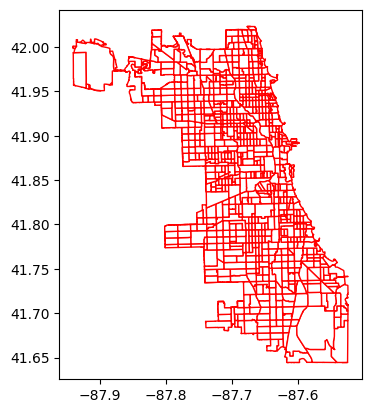

In [31]:
branchCopy = gpd.GeoDataFrame(
     branchCopy, geometry=gpd.points_from_xy(branchCopy.Longitude, branchCopy.Latitude), crs="EPSG:3435")

base = censusTracts.plot(color='white', edgecolor='red')


<Axes: title={'center': 'Raw Score'}>

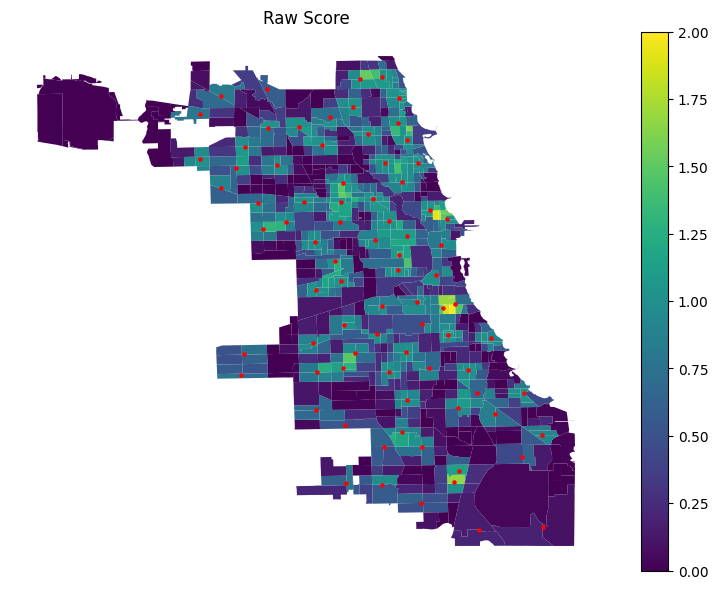

In [32]:
ax = censusTracts.plot(column = 'raw score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Raw Score Normalized'}>

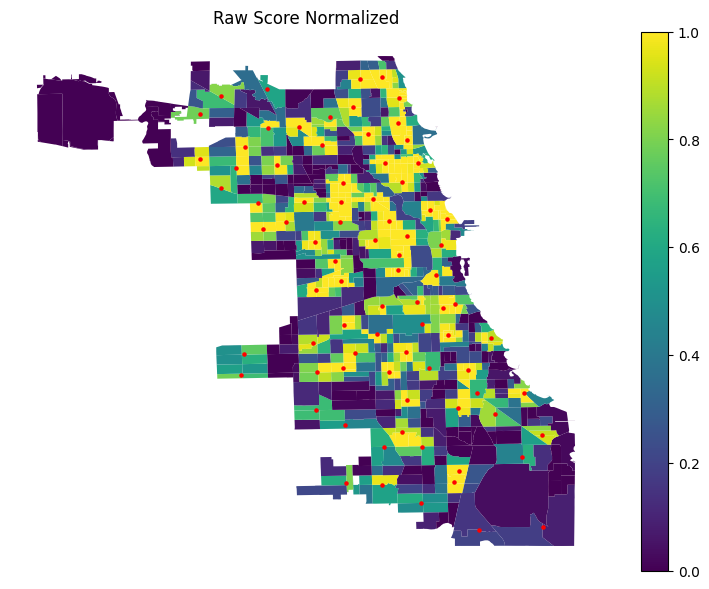

In [33]:
ax = censusTracts.plot(column = 'raw score norm', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Raw Score Normalized")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5, edgecolor='red')


<Axes: title={'center': 'Percent Access to at Least One Library: 15 Minutes Walking'}>

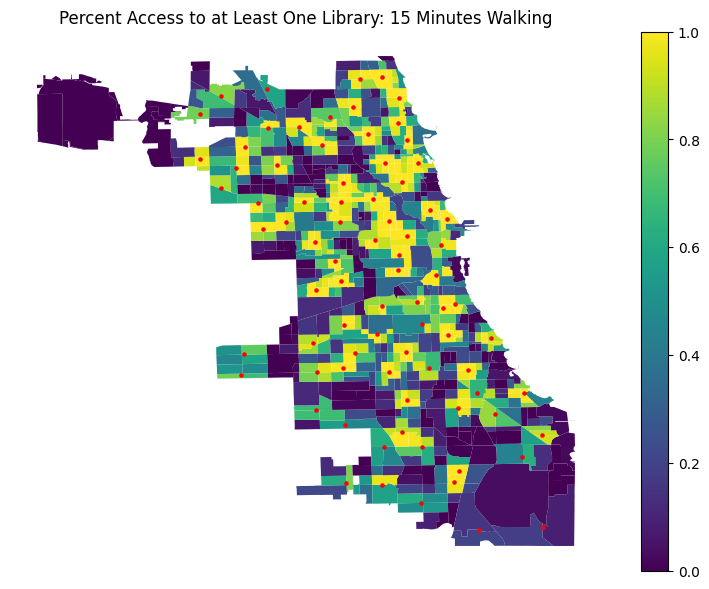

In [34]:
ax = censusTracts.plot(column = 'percent covered by at least one library', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent Access to at Least One Library: 15 Minutes Walking")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


<Axes: title={'center': 'Weighted Score'}>

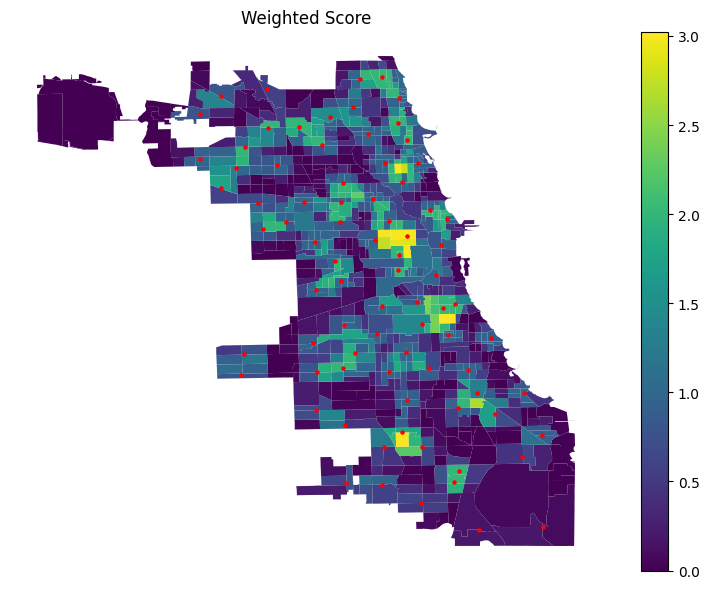

In [35]:
ax = censusTracts.plot(column = 'weighted score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Weighted Score")
branchCopy.plot(ax=ax, marker='o', color='red', markersize=5)


In [36]:
demographics = pd.read_csv('../data/clean/census_demos.csv')
demographics

,geoid,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.052230,0.040404,0.069475,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360
1,17031823304,"Census Tract 8233.04, Cook County, Illinois",MULTIPOLYGON (((-87.72003618903081 41.68396731...,6316,0.060798,0.063965,0.094205,0.057948,0.056365,0.066498,...,0.787775,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807
2,17031740400,"Census Tract 7404, Cook County, Illinois","POLYGON ((-87.72008 41.691274, -87.719372 41.6...",4738,0.067750,0.060996,0.082946,0.063529,0.068383,0.064373,...,0.918216,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337
3,17031740300,"Census Tract 7403, Cook County, Illinois","POLYGON ((-87.720431 41.698569, -87.720066 41....",5017,0.068567,0.073749,0.069962,0.042456,0.028304,0.067570,...,0.948943,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476
4,17031822802,"Census Tract 8228.02, Cook County, Illinois","MULTIPOLYGON (((-87.720752 41.702042, -87.7207...",3750,0.055200,0.114667,0.068000,0.081600,0.030933,0.027467,...,0.885246,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,"Census Tract 3204, Cook County, Illinois","POLYGON ((-87.627636 41.882057, -87.627594 41....",3058,0.003924,0.003597,0.000000,0.300523,0.325049,0.050033,...,NaN,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052
865,17031320101,"Census Tract 3201.01, Cook County, Illinois","POLYGON ((-87.620855 41.881881, -87.620825 41....",7952,0.026157,0.038481,0.005282,0.020372,0.032193,0.095825,...,0.953413,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799
866,17031081403,"Census Tract 814.03, Cook County, Illinois","MULTIPOLYGON (((-87.624311 41.889115, -87.6243...",8984,0.028718,0.002894,0.005677,0.000000,0.108081,0.220837,...,0.996585,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500
867,17031081402,"Census Tract 814.02, Cook County, Illinois","POLYGON ((-87.617537 41.893453, -87.617164 41....",5613,0.051309,0.042936,0.010868,0.012649,0.055407,0.155175,...,0.969296,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482


In [37]:
censusTracts = censusTracts.drop(columns = ['qualifying name','polygons in census','area coverage of each polygon in census'])

In [38]:
demographics = demographics.drop(columns = 'geometry')

In [39]:
ctm = censusTracts.merge(demographics, on = 'geoid')
ctmcopy = ctm

In [40]:
ctm.set_index('geoid', inplace = True)


In [41]:
ctm = ctm.drop(columns = ['qualifying name','geometry'])

In [42]:
popd = pop[['geoid','population density (per sq. mile)']]

In [43]:
ctm = ctm.merge(popd, on='geoid')

In [44]:
ctm

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
0,17031823303,0.000000,1.081697e+00,0.000000,0.000000,0.0,0.000000,0.000000,4059,0.047056,...,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360,5233.042
1,17031823304,0.537428,3.526503e+05,0.537428,0.537428,1.0,0.537428,0.537428,6316,0.060798,...,0.212225,0.691724,0.603388,0.304465,0.001742,0.008233,0.0,0.037365,0.044807,4603.753
2,17031740400,0.215277,2.782659e+06,0.215277,0.215277,1.0,0.215277,0.215277,4738,0.067750,...,0.081784,0.836431,0.879907,0.058041,0.000000,0.032714,0.0,0.000000,0.029337,4322.723
3,17031740300,0.621771,1.319688e+06,0.621771,0.621771,1.0,0.621771,0.621771,5017,0.068567,...,0.051057,0.929345,0.906119,0.015547,0.000000,0.008372,0.0,0.033486,0.036476,9838.490
4,17031822802,0.000000,1.577396e+01,0.000000,0.000000,0.0,0.000000,0.000000,3750,0.055200,...,0.114754,0.850898,0.849067,0.049333,0.001333,0.018933,0.0,0.022400,0.058933,7442.477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,17031320400,0.977591,8.033379e+05,0.977591,0.977591,1.0,0.977591,0.977591,3058,0.003924,...,NaN,0.904269,0.678548,0.107914,0.000000,0.149444,0.0,0.015043,0.049052,9849.455
865,17031320101,0.114623,4.902799e+05,0.114623,0.114623,2.0,0.114623,0.229245,7952,0.026157,...,0.046587,0.791776,0.594693,0.067404,0.000000,0.234406,0.0,0.053697,0.049799,44222.540
866,17031081403,0.471778,5.956278e+05,0.471778,0.471778,1.0,0.471778,0.471778,8984,0.028718,...,0.003415,0.920150,0.616874,0.019368,0.000000,0.306879,0.0,0.025378,0.031500,70236.120
867,17031081402,0.190593,5.776787e+05,0.190593,0.190593,1.0,0.190593,0.190593,5613,0.051309,...,0.030704,0.918122,0.619277,0.049172,0.003029,0.240869,0.0,0.018172,0.069482,24655.630


In [45]:
corrRawScore = ctm.corrwith(ctm['raw score'])
cRaw = corrRawScore.to_frame()
cRaw=cRaw.sort_values(by = 0)
cRaw.drop(axis = 'index', index=['weighted score', 'raw score norm', 'percent covered by at least one library', 'added percentages', 'number of polygons in census tract'])

,0
Percent Workers 16+: Drove Alone,-0.336226
"Percent Workers 16+: Car, Truck, or Van",-0.329290
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.258455
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.228419
Percent: 10 to 14 years,-0.226889
...,...
Percent: 25 to 29 years,0.257518
Percent Owner and Renter Occupied Housing: No Vehicles,0.263099
Percent Workers 16+: Public Transportation (Includes Taxi),0.280260
population density (per sq. mile),0.306963


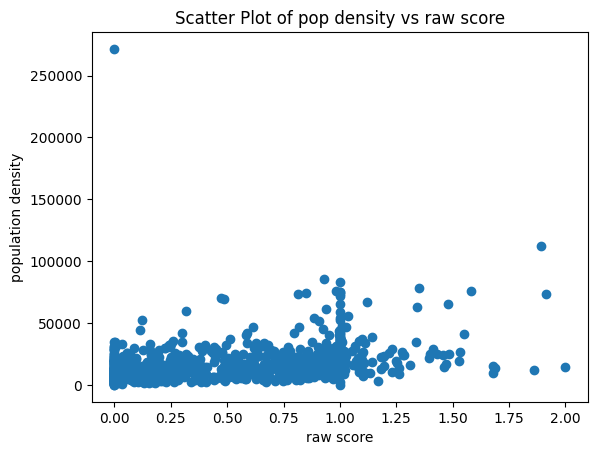

In [46]:
plt.scatter(ctm['raw score'], ctm['population density (per sq. mile)'])
plt.xlabel('raw score')
plt.ylabel('population density')
plt.title('Scatter Plot of pop density vs raw score')
plt.show()

In [47]:
corrRawScoreN = ctm.corrwith(ctm['raw score norm'])
cRawN = corrRawScoreN.to_frame()
cRawN = cRawN.sort_values(by = 0)
cRawN.drop(axis = 'index', index=['weighted score', 'raw score', 'percent covered by at least one library', 'added percentages', 'number of polygons in census tract'])

,0
Percent Workers 16+: Drove Alone,-0.323682
"Percent Workers 16+: Car, Truck, or Van",-0.317062
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.255553
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.219977
Percent: 10 to 14 years,-0.218186
...,...
Percent: 25 to 29 years,0.249283
Percent Owner and Renter Occupied Housing: No Vehicles,0.249765
Percent Workers 16+: Public Transportation (Includes Taxi),0.281882
population density (per sq. mile),0.288207


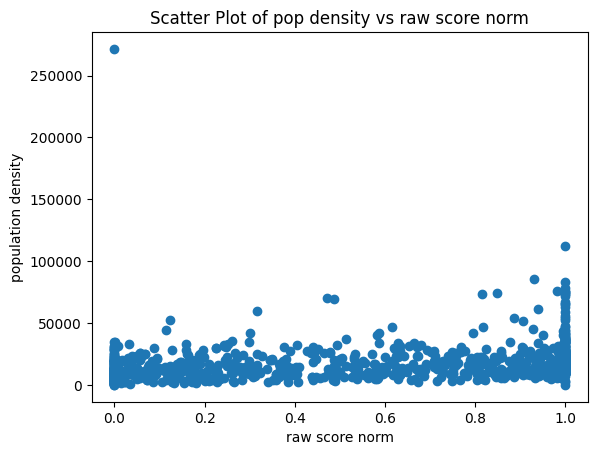

In [48]:
plt.scatter(ctm['raw score norm'], ctm['population density (per sq. mile)'])
plt.xlabel('raw score norm')
plt.ylabel('population density')
plt.title('Scatter Plot of pop density vs raw score norm')
plt.show()

In [49]:
corrWeightedScore = ctm.corrwith(ctm['weighted score'])
cWeight = corrWeightedScore.to_frame()
cWeight = cWeight.sort_values(by = 0)
cWeight.drop(axis = 'index', index=['raw score norm', 'raw score', 'percent covered by at least one library', 'added percentages', 'number of polygons in census tract'])

,0
Percent Workers 16+: Drove Alone,-0.305848
"Percent Workers 16+: Car, Truck, or Van",-0.290851
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.247742
Percent: 10 to 14 years,-0.225678
Percent Owner and Renter Occupied Housing: 4 Vehicles,-0.197760
...,...
Percent Renter-Occupied Housing: No Vehicles,0.220450
Percent Owner and Renter Occupied Housing: No Vehicles,0.233305
Percent Workers 16+: Public Transportation (Includes Taxi),0.239748
Percent: 25 to 29 years,0.245109


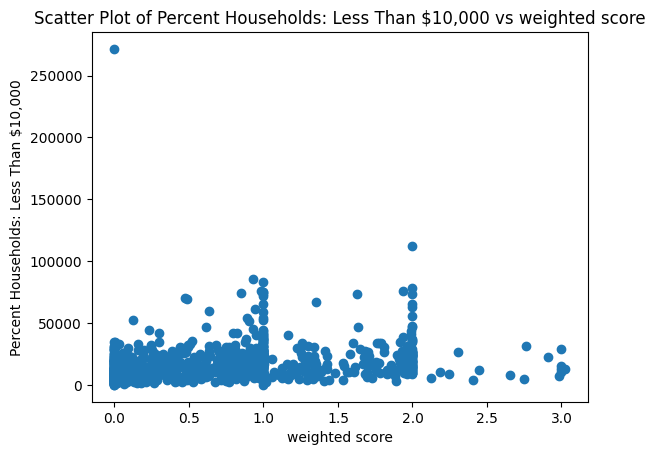

In [50]:
plt.scatter(ctm['weighted score'], ctm['population density (per sq. mile)'])
plt.xlabel('weighted score')
plt.ylabel('Percent Households: Less Than $10,000')
plt.title('Scatter Plot of Percent Households: Less Than $10,000 vs weighted score')
plt.show()

In [51]:
corrCovPer = ctm.corrwith(ctm['percent covered by at least one library'])
cCovPer = corrCovPer.to_frame()
cCovPer = cCovPer.sort_values(by = 0)
cCovPer.drop(axis = 'index', index=['raw score norm', 'raw score', 'weighted score', 'added percentages', 'number of polygons in census tract'])

,0
Percent Workers 16+: Drove Alone,-0.322092
"Percent Workers 16+: Car, Truck, or Van",-0.317013
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.253462
Percent Owner and Renter Occupied Housing: 2 Vehicles,-0.217440
Percent: 10 to 14 years,-0.213946
...,...
Percent Owner and Renter Occupied Housing: No Vehicles,0.246118
Percent: 25 to 29 years,0.246876
Percent Workers 16+: Public Transportation (Includes Taxi),0.282705
population density (per sq. mile),0.288405


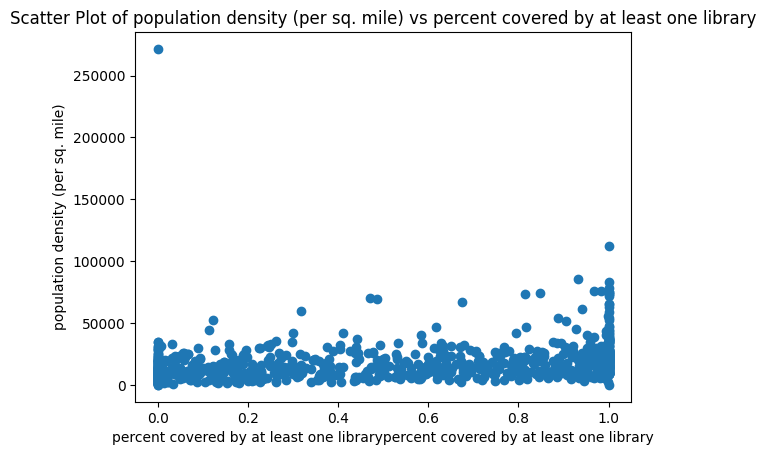

In [52]:
plt.scatter(ctm['percent covered by at least one library'], ctm['population density (per sq. mile)'])
plt.xlabel('percent covered by at least one librarypercent covered by at least one library')
plt.ylabel('population density (per sq. mile)')
plt.title('Scatter Plot of population density (per sq. mile) vs percent covered by at least one library')
plt.show()

<Axes: >

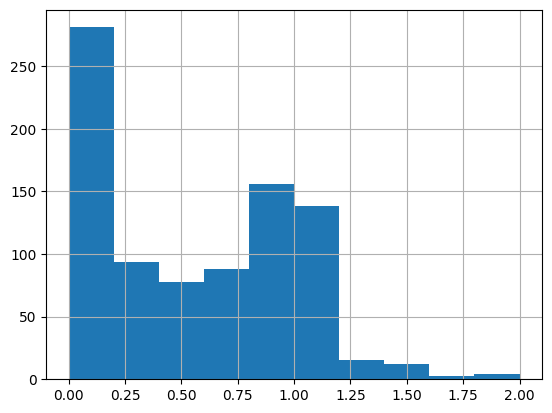

In [53]:
ctm['raw score'].hist()

<Axes: >

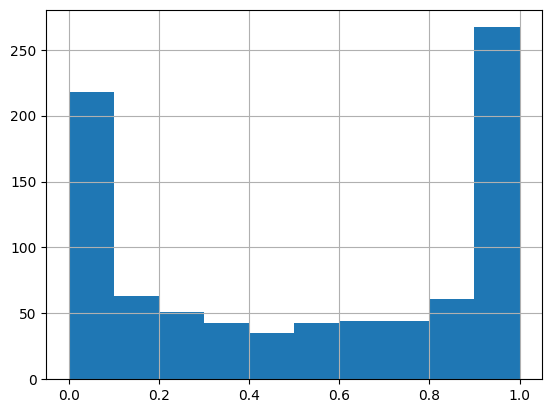

In [54]:
ctm['raw score norm'].hist()

<Axes: >

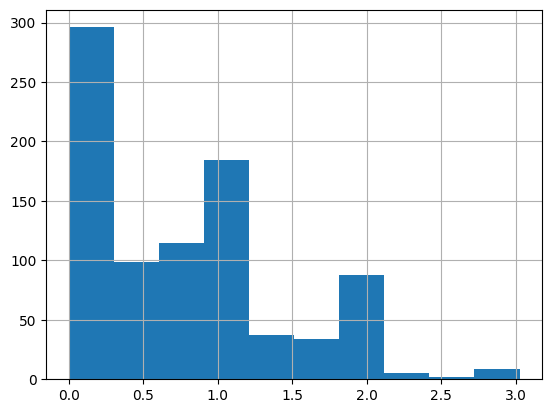

In [55]:
ctm['weighted score'].hist()

<Axes: >

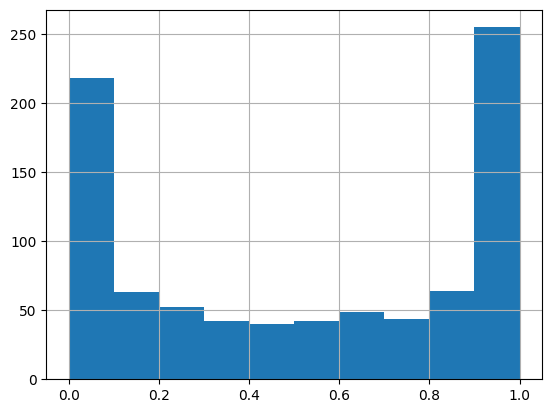

In [56]:
ctm['percent covered by at least one library'].hist()

In [57]:
ctmpercent0 = ctm.loc[ctm['percent covered by at least one library'] <= 0.004]
ctmpercent0.sort_values(by = 'percent covered by at least one library')

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
0,17031823303,0.000000,1.081697,0.000000,0.000000,0.0,0.000000,0.000000,4059,0.047056,...,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.000000,0.072924,0.043360,5233.042
638,17031071400,0.000000,671705.806465,0.000000,0.000000,0.0,0.000000,0.000000,4799,0.011877,...,0.024297,0.954530,0.850177,0.041050,0.000000,0.060221,0.000000,0.020421,0.028131,19403.490
634,17031071600,0.000000,162168.125371,0.000000,0.000000,0.0,0.000000,0.000000,1969,0.096496,...,0.054305,0.917881,0.801930,0.066531,0.000000,0.099543,0.000000,0.009142,0.022854,31446.740
604,17031050900,0.000000,162720.832699,0.000000,0.000000,0.0,0.000000,0.000000,1532,0.058094,...,0.012346,0.970679,0.828329,0.024151,0.000000,0.031984,0.000000,0.057441,0.058094,24384.000
602,17031210100,0.000000,854096.520377,0.000000,0.000000,0.0,0.000000,0.000000,4162,0.064152,...,0.044669,0.899345,0.628063,0.030274,0.000000,0.054301,0.000000,0.196060,0.091302,12892.350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,17031161100,0.002371,576828.385007,0.002371,0.002371,1.0,0.002371,0.002371,2171,0.116997,...,0.011583,0.980695,0.737448,0.103639,0.000000,0.029940,0.000000,0.021649,0.107324,9747.870
537,17031191200,0.002853,705574.850627,0.002853,0.002853,1.0,0.002853,0.002853,4127,0.109280,...,0.045788,0.784799,0.442937,0.037073,0.000000,0.004604,0.005573,0.340441,0.169372,15149.130
459,17031252202,0.003191,637446.509375,0.003191,0.003191,1.0,0.003191,0.003191,4795,0.096976,...,0.087311,0.831781,0.007508,0.964338,0.000000,0.017518,0.002086,0.005839,0.002711,19482.420
331,17031380100,0.003312,438045.042101,0.003312,0.003312,1.0,0.003312,0.003312,1984,0.045363,...,0.196130,0.706245,0.047379,0.904234,0.007560,0.000504,0.000000,0.000000,0.040323,11730.530


In [113]:
ctmpercent0to50 = ctm.loc[ctm['percent covered by at least one library'] < 0.5]
ctmpercent0to50.sort_values(by = 'percent covered by at least one library')

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
0,17031823303,0.000000,1.081697e+00,0.000000,0.000000,0.0,0.000000,0.000000,4059,0.047056,...,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.000000,0.072924,0.043360,5233.042
426,17031291600,0.000000,2.203403e+05,0.000000,0.000000,0.0,0.000000,0.000000,1396,0.042980,...,0.041905,0.899048,0.357450,0.048711,0.000000,0.000000,0.000000,0.530086,0.063754,16409.290
438,17031813801,0.000000,7.528581e+03,0.000000,0.000000,0.0,0.000000,0.000000,3318,0.075347,...,0.173293,0.743119,0.158228,0.015069,0.023810,0.000000,0.002411,0.783002,0.017480,10210.690
439,17031813500,0.000000,3.166734e+00,0.000000,0.000000,0.0,0.000000,0.000000,6323,0.061521,...,0.107396,0.844478,0.309505,0.069904,0.005377,0.012178,0.000000,0.522853,0.080183,19865.630
440,17031813400,0.000000,7.897302e+00,0.000000,0.000000,0.0,0.000000,0.000000,8516,0.079967,...,0.081110,0.846852,0.304721,0.021137,0.000000,0.009512,0.000000,0.545092,0.119540,19870.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,17031231500,0.487397,9.997103e+05,0.487397,0.487397,2.0,0.487397,0.974793,5865,0.056266,...,0.097255,0.891112,0.048423,0.745610,0.000000,0.000000,0.000000,0.205968,0.000000,15194.750
37,17031530200,0.491106,1.297346e+06,0.491106,0.491106,1.0,0.491106,0.491106,4406,0.083296,...,0.178571,0.700000,0.008398,0.874035,0.000000,0.000000,0.000000,0.031775,0.085792,8796.045
239,17031690500,0.492352,3.231626e+05,0.492352,0.492352,1.0,0.492352,0.492352,898,0.032294,...,0.060345,0.787356,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7197.061
673,17031061500,0.492735,1.629110e+05,0.492735,0.492735,1.0,0.492735,0.492735,2050,0.040000,...,NaN,0.964405,0.834634,0.039512,0.002927,0.032195,0.000000,0.013171,0.077561,32590.860


In [114]:
ctmpercent50to100 = ctm.loc[ctm['percent covered by at least one library'] >= 0.5]
ctmpercent50to100.sort_values(by = 'percent covered by at least one library')

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
162,17031660600,0.500201,6.586087e+05,0.500201,0.500201,2.0,0.500201,1.000403,5266,0.101785,...,0.211123,0.717817,0.280479,0.436384,0.006077,0.000000,0.0,0.136726,0.140334,20708.640
442,17031292200,0.576363,3.941613e+05,0.576363,0.500772,2.0,0.576363,1.001544,2580,0.072868,...,0.168574,0.765869,0.044574,0.857752,0.000000,0.012403,0.0,0.069767,0.015504,16952.940
471,17031836800,0.500804,8.160162e+05,0.500804,0.500804,2.0,0.500804,1.001608,2634,0.121109,...,0.139073,0.788079,0.047077,0.948368,0.004556,0.000000,0.0,0.000000,0.000000,8507.596
127,17031560900,0.501153,1.310849e+06,0.501153,0.501153,1.0,0.501153,0.501153,5394,0.069522,...,0.062366,0.879570,0.780682,0.000185,0.000000,0.011865,0.0,0.098072,0.109195,10589.570
854,17031010400,0.504384,5.438183e+05,0.504384,0.504384,2.0,0.504384,1.008767,4587,0.005232,...,0.176991,0.731072,0.788969,0.108568,0.000000,0.052322,0.0,0.015697,0.034445,21649.270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,17031630800,1.483469,6.558127e+05,1.483469,1.000000,2.0,1.000000,2.000000,6358,0.052218,...,0.150319,0.823564,0.353098,0.015728,0.039478,0.002831,0.0,0.498899,0.089965,25109.430
616,17031080202,1.342733,1.552404e+05,1.342733,1.000000,2.0,1.000000,2.000000,3758,0.019691,...,0.011966,0.917032,0.888238,0.020224,0.000000,0.043374,0.0,0.009580,0.038584,62697.600
83,17031730201,1.181204,9.988290e+05,1.181204,1.000000,3.0,1.000000,3.000000,5075,0.024828,...,0.090997,0.750120,0.038227,0.947389,0.000000,0.004335,0.0,0.000000,0.010049,13159.560
403,17031243300,1.004774,3.270928e+05,1.004774,1.000000,2.0,1.000000,2.000000,2191,0.041077,...,0.074940,0.893634,0.785030,0.040164,0.000000,0.040164,0.0,0.109995,0.024646,17348.780


In [115]:
ctmpercent0to50 = ctmpercent0to50.drop(columns =['number of polygons in census tract','geoid','raw score', 'Area','raw score norm', 'weighted score', 'added percentages', 'percent covered by at least one library'])
ctmpercent50to100 = ctmpercent50to100.drop(columns =['number of polygons in census tract','geoid','raw score', 'Area','raw score norm', 'weighted score', 'added percentages', 'percent covered by at least one library'])

In [61]:
ctmpercent0['class'] = 0
ctmpercent0 = ctmpercent0.drop(columns =['number of polygons in census tract','geoid','raw score', 'Area','raw score norm', 'weighted score', 'added percentages', 'percent covered by at least one library'])

/tmp/ipykernel_2548890/1290006174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctmpercent0['class'] = 0


In [62]:
#ctmpercent0 = ctmpercent0.set_index('geoid')

In [63]:
ctmpercent1 = ctm.loc[ctm['percent covered by at least one library'] >= .995]
ctmpercent1.sort_values(by = 'percent covered by at least one library')

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
762,17031140400,1.009005,1.181559e+06,1.009005,0.995870,2.0,1.000000,1.991740,5765,0.046314,...,0.087118,0.905468,0.566522,0.016999,0.014397,0.203816,0.0,0.140503,0.057762,12636.930
412,17031301702,0.995886,3.309910e+05,0.995886,0.995886,1.0,0.995886,0.995886,3617,0.083218,...,0.056162,0.847894,0.374620,0.000000,0.000000,0.000000,0.0,0.534421,0.090959,28303.020
585,17031190401,0.996202,6.554733e+05,0.996202,0.996202,1.0,0.996202,0.996202,4227,0.033594,...,0.040551,0.844682,0.460610,0.029808,0.000000,0.080672,0.0,0.352732,0.076177,16702.210
615,17031081202,1.550739,2.265701e+05,1.550739,0.996497,2.0,1.000000,1.992995,3275,0.050992,...,0.004683,0.931322,0.845191,0.033588,0.000000,0.031756,0.0,0.022595,0.066870,41514.140
660,17031070300,0.996526,3.244072e+05,0.996526,0.996519,2.0,0.996526,1.993037,3558,0.023328,...,0.006262,0.976205,0.895728,0.007307,0.000000,0.044969,0.0,0.004497,0.047499,28405.870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,17031630800,1.483469,6.558127e+05,1.483469,1.000000,2.0,1.000000,2.000000,6358,0.052218,...,0.150319,0.823564,0.353098,0.015728,0.039478,0.002831,0.0,0.498899,0.089965,25109.430
616,17031080202,1.342733,1.552404e+05,1.342733,1.000000,2.0,1.000000,2.000000,3758,0.019691,...,0.011966,0.917032,0.888238,0.020224,0.000000,0.043374,0.0,0.009580,0.038584,62697.600
83,17031730201,1.181204,9.988290e+05,1.181204,1.000000,3.0,1.000000,3.000000,5075,0.024828,...,0.090997,0.750120,0.038227,0.947389,0.000000,0.004335,0.0,0.000000,0.010049,13159.560
403,17031243300,1.004774,3.270928e+05,1.004774,1.000000,2.0,1.000000,2.000000,2191,0.041077,...,0.074940,0.893634,0.785030,0.040164,0.000000,0.040164,0.0,0.109995,0.024646,17348.780


In [64]:
ctmpercent1['class'] = 1
ctmpercent1 = ctmpercent1.drop(columns =['number of polygons in census tract','geoid','raw score', 'Area','raw score norm', 'weighted score', 'added percentages', 'percent covered by at least one library'])

/tmp/ipykernel_2548890/484874520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctmpercent1['class'] = 1


In [65]:
#ctmpercent1 = ctmpercent1.set_index('geoid')

In [66]:
#ctmpercent0 = ctmpercent0.reset_index()

In [67]:
#ctmpercent0 = ctmpercent0.drop(columns='index')


In [68]:
ctmpercent1.iloc[0:161]

,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,Percent: 30 to 34 years,Percent: 35 to 39 years,Percent: 40 to 44 years,...,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile),class
49,3093,0.104429,0.084707,0.046233,0.047203,0.055609,0.099580,0.067572,0.068542,0.047203,...,0.714765,0.000323,0.999677,0.000000,0.000000,0.000000,0.000000,0.000000,9475.207,1
52,4573,0.068664,0.079598,0.043079,0.055543,0.055981,0.058605,0.104527,0.084190,0.029521,...,0.800456,0.000000,0.983818,0.000000,0.007216,0.000000,0.004373,0.004592,9902.477,1
82,1011,0.028684,0.064293,0.030663,0.078140,0.033630,0.066271,0.039565,0.007913,0.047478,...,0.613990,0.000000,0.976261,0.000000,0.009891,0.000000,0.000000,0.013848,8805.425,1
83,5075,0.024828,0.017931,0.063448,0.070936,0.084335,0.071921,0.099310,0.027389,0.106207,...,0.750120,0.038227,0.947389,0.000000,0.004335,0.000000,0.000000,0.010049,13159.560,1
118,2798,0.114010,0.026090,0.072194,0.074339,0.096855,0.030021,0.084703,0.077198,0.096855,...,0.816535,0.000000,0.926376,0.000000,0.002502,0.000000,0.048606,0.022516,11035.420,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,5995,0.056380,0.031860,0.035530,0.013344,0.084737,0.101918,0.163470,0.107923,0.068724,...,0.903922,0.688073,0.029191,0.000000,0.032193,0.007173,0.028691,0.214679,23306.850,1
848,2459,0.000000,0.010573,0.037414,0.210655,0.209028,0.126068,0.078487,0.069947,0.046767,...,0.851085,0.546564,0.212281,0.006100,0.121594,0.000000,0.031720,0.081741,73516.180,1
851,4959,0.080056,0.072999,0.047792,0.038314,0.058278,0.092357,0.189151,0.055253,0.115346,...,0.847673,0.439000,0.203468,0.000000,0.064327,0.000000,0.136318,0.156886,19419.210,1
853,6553,0.028079,0.070502,0.024416,0.075996,0.092019,0.110636,0.074622,0.094613,0.060736,...,0.916352,0.571189,0.217000,0.000000,0.040439,0.000000,0.106516,0.064856,34286.080,1


In [69]:
ctmScore = pd.concat([ctmpercent0,ctmpercent1], ignore_index=True)

In [70]:
ctmmid = ctm.loc[ctm['percent covered by at least one library'] < .995]
ctmmid.sort_values(by = 'percent covered by at least one library')

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
0,17031823303,0.000000,1.081697,0.000000,0.000000,0.0,0.000000,0.000000,4059,0.047056,...,0.087199,0.806432,0.795763,0.078098,0.009855,0.000000,0.0,0.072924,0.043360,5233.042
281,17031410500,0.000000,263010.229221,0.000000,0.000000,0.0,0.000000,0.000000,2891,0.019370,...,0.034371,0.902724,0.404704,0.382567,0.000000,0.152888,0.0,0.009685,0.050156,28468.980
316,17031390300,0.000000,327048.938195,0.000000,0.000000,0.0,0.000000,0.000000,2890,0.075433,...,0.156342,0.666667,0.125606,0.863668,0.002076,0.000000,0.0,0.001384,0.007266,22886.540
332,17031836400,0.000000,821123.020668,0.000000,0.000000,0.0,0.000000,0.000000,3891,0.106913,...,0.114745,0.812869,0.037779,0.866872,0.030069,0.006682,0.0,0.006939,0.051658,12611.020
378,17031843300,0.000000,584250.436820,0.000000,0.000000,0.0,0.000000,0.000000,1558,0.065469,...,0.152000,0.762667,0.131579,0.677150,0.000000,0.016046,0.0,0.080873,0.094352,6906.623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,17031243100,1.025795,324004.824767,1.025795,0.992637,2.0,1.000000,1.985274,2225,0.095730,...,0.001059,0.994703,0.695281,0.008090,0.000000,0.064719,0.0,0.056180,0.175730,17785.960
710,17031160502,0.993520,310885.048675,0.993520,0.993520,1.0,0.993520,0.993520,3919,0.083950,...,0.029683,0.854222,0.597346,0.018372,0.000000,0.066599,0.0,0.162797,0.154886,32649.040
393,17031081500,0.994485,295808.319528,0.994485,0.994377,2.0,0.994485,1.988754,4766,0.035040,...,NaN,0.961141,0.602392,0.021611,0.000210,0.351028,0.0,0.012589,0.012170,43367.410
362,17031330103,0.994403,509667.218740,0.994403,0.994403,1.0,0.994403,0.994403,7928,0.030903,...,0.011526,0.929136,0.606458,0.280020,0.007190,0.103305,0.0,0.000757,0.002270,40288.000


In [71]:
ctmmid = ctmmid.loc[ctmmid['percent covered by at least one library'] > 0.004]
ctmmid.sort_values(by = 'percent covered by at least one library')

,geoid,raw score,Area,added percentages,percent covered by at least one library,number of polygons in census tract,raw score norm,weighted score,total population,Percent: under 5 years,...,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,population density (per sq. mile)
344,17031600700,0.006362,4.871063e+05,0.006362,0.006362,1.0,0.006362,0.006362,2703,0.063633,...,0.009649,0.900877,0.226045,0.000000,0.044025,0.616722,0.0,0.048465,0.064743,15652.820
675,17031061200,0.007350,1.746704e+05,0.007350,0.007350,1.0,0.007350,0.007350,2095,0.049165,...,0.007308,0.964677,0.884487,0.016229,0.000000,0.031981,0.0,0.027685,0.039618,31064.440
60,17031490500,0.007473,1.424111e+06,0.007473,0.007473,1.0,0.007473,0.007473,2065,0.011622,...,0.101717,0.859974,0.038257,0.934140,0.000000,0.015012,0.0,0.000000,0.012591,3755.554
100,17031460400,0.008431,6.525283e+05,0.008431,0.008431,1.0,0.008431,0.008431,3619,0.094778,...,0.104375,0.831159,0.002487,0.979552,0.000000,0.003868,0.0,0.000000,0.014092,14364.460
58,17031500100,0.009473,2.651675e+06,0.009473,0.009473,1.0,0.009473,0.009473,3308,0.025695,...,0.035962,0.794322,0.018138,0.981862,0.000000,0.000000,0.0,0.000000,0.000000,3231.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,17031243100,1.025795,3.240048e+05,1.025795,0.992637,2.0,1.000000,1.985274,2225,0.095730,...,0.001059,0.994703,0.695281,0.008090,0.000000,0.064719,0.0,0.056180,0.175730,17785.960
710,17031160502,0.993520,3.108850e+05,0.993520,0.993520,1.0,0.993520,0.993520,3919,0.083950,...,0.029683,0.854222,0.597346,0.018372,0.000000,0.066599,0.0,0.162797,0.154886,32649.040
393,17031081500,0.994485,2.958083e+05,0.994485,0.994377,2.0,0.994485,1.988754,4766,0.035040,...,NaN,0.961141,0.602392,0.021611,0.000210,0.351028,0.0,0.012589,0.012170,43367.410
362,17031330103,0.994403,5.096672e+05,0.994403,0.994403,1.0,0.994403,0.994403,7928,0.030903,...,0.011526,0.929136,0.606458,0.280020,0.007190,0.103305,0.0,0.000757,0.002270,40288.000


In [72]:
ctmmid['class'] = 2
#ctmmid = ctmmid.drop(columns =['number of polygons in census tract','geoid','raw score', 'Area','raw score norm', 'weighted score', 'added percentages')

In [73]:
corrCovPer = ctmmid.corrwith(ctmmid['percent covered by at least one library'])
cCovPer = corrCovPer.to_frame()
cCovPer = cCovPer.sort_values(by = 0)
cCovPer.drop(axis = 'index', index=['raw score norm', 'raw score', 'weighted score', 'added percentages', 'number of polygons in census tract'])

,0
Area,-0.205829
Percent: 10 to 14 years,-0.126454
"Percent Workers 16+: Car, Truck, or Van",-0.124629
Percent Workers 16+: Drove Alone,-0.119239
Percent Owner and Renter Occupied Housing: 3 Vehicles,-0.103125
...,...
Percent Owner and Renter Occupied Housing: No Vehicles,0.102792
Percent Workers 16+: Public Transportation (Includes Taxi),0.106527
population density (per sq. mile),0.237613
percent covered by at least one library,1.000000


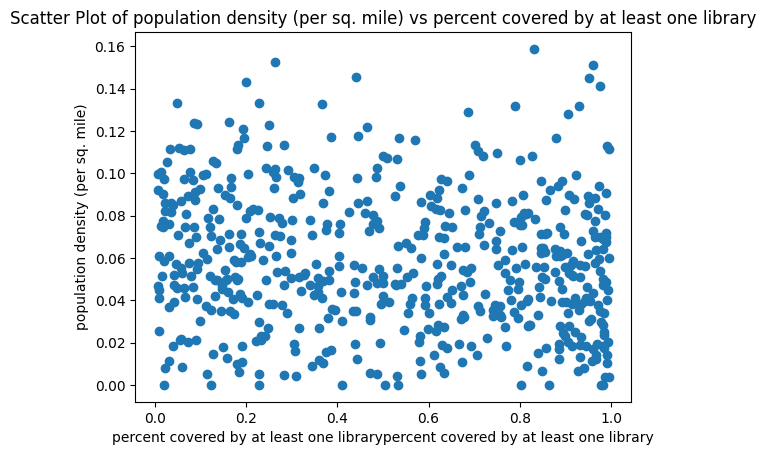

In [74]:
plt.scatter(ctmmid['percent covered by at least one library'], ctmmid['Percent: 10 to 14 years'])
plt.xlabel('percent covered by at least one librarypercent covered by at least one library')
plt.ylabel('population density (per sq. mile)')
plt.title('Scatter Plot of population density (per sq. mile) vs percent covered by at least one library')
plt.show()

<Axes: >

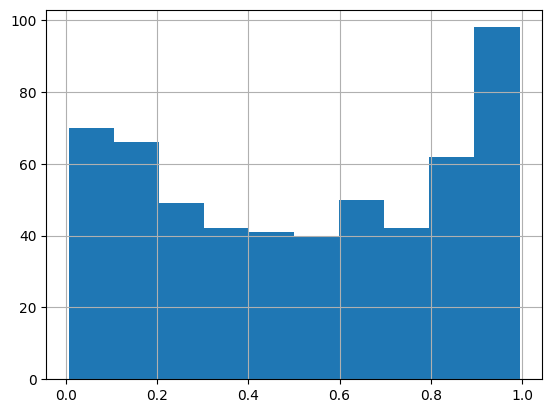

In [75]:
ctmmid['percent covered by at least one library'].hist()

In [122]:
zeroMean = pd.DataFrame(ctmpercent0.mean())
oneMean = pd.DataFrame(ctmpercent1.mean())
diff = oneMean - zeroMean
diff.loc[diff[0] > .01]

,0
Percent: 20 to 24 years,0.021946
Percent: 25 to 29 years,0.052116
Percent: 30 to 34 years,0.032560
Percent: 35 to 39 years,0.010247
Percent Owner and Renter Occupied Housing: No Vehicles,0.132846
Percent Owner and Renter Occupied Housing: 1 Vehicle,0.047380
renter-occupied housing units,229.764982
Percent Renter-Occupied Housing: No Vehicles,0.144912
Percent Workers 16+: Public Transportation (Includes Taxi),0.124275
Percent Workers 16+: Walked,0.033795


In [124]:
zeroToFiftyMean = pd.DataFrame(ctmpercent0to50.mean())
fiftyToOneHundredMean = pd.DataFrame(ctmpercent50to100.mean())
diff2 = fiftyToOneHundredMean - zeroToFiftyMean
diff2.loc[diff2[0] > .01]

,0
Percent: 20 to 24 years,0.011097
Percent: 25 to 29 years,0.023413
Percent: 30 to 34 years,0.015523
occupied housing units,30.766371
Percent Owner and Renter Occupied Housing: No Vehicles,0.058255
renter-occupied housing units,134.436882
Percent Renter-Occupied Housing: No Vehicles,0.060695
workers 16 years and over,57.616862
Percent Workers 16+: Public Transportation (Includes Taxi),0.054040
Percent Workers 16+: Walked,0.015428


<Axes: >

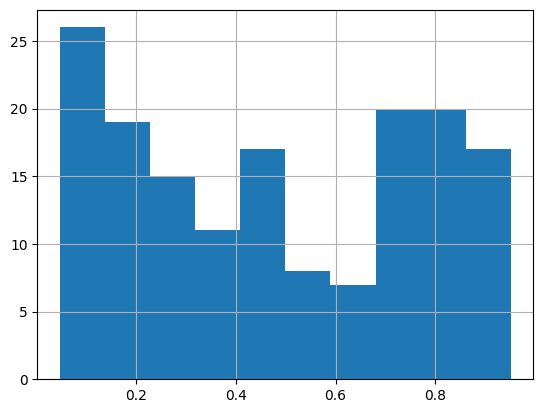

In [85]:
ctmpercent1['Percent: 25+ Bachelor\'s Degree or More'].hist()

<Axes: >

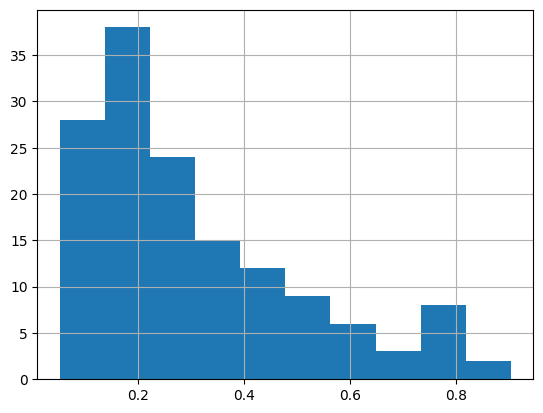

In [86]:
ctmpercent0['Percent: 25+ Bachelor\'s Degree or More'].hist()

In [87]:
diff1min0 = oneMean-zeroMean
diff0min1 = zeroMean-oneMean

0

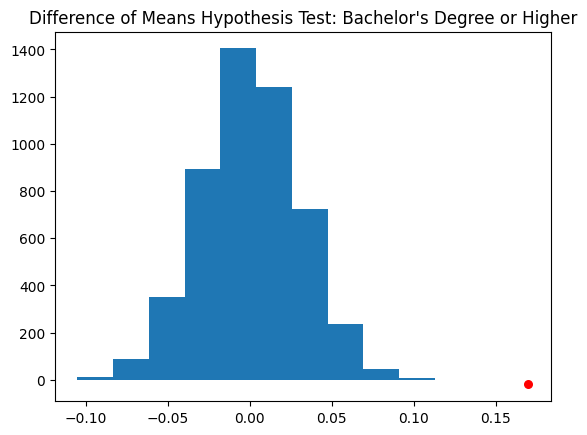

In [125]:
zeros = ctmpercent0['Percent: 25+ Bachelor\'s Degree or More']
ones = ctmpercent1['Percent: 25+ Bachelor\'s Degree or More']

[len(zeros), len(ones)]

zeros = zeros.dropna()
ones= ones.dropna()
[len(zeros), len(ones)]
shuffled_combine = np.random.permutation(np.append(zeros, ones))
shuffled_0 = shuffled_combine[0:145]
shuffled_1 = shuffled_combine[145:(145 + 160)]

np.mean(shuffled_0) - np.mean(shuffled_1)

test_stat = np.mean(ones) - np.mean(zeros)
round(test_stat, 2)

differences = np.array([])

for i in np.arange(5000):
    shuffled_combine = np.random.permutation(np.append(zeros, ones))
    shuffled_0 = shuffled_combine[0:145]
    shuffled_1 = shuffled_combine[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences = np.append(differences, np.mean(shuffled_1) - np.mean(shuffled_0) )

plt.hist(differences)
plt.title("Difference of Means Hypothesis Test: Bachelor's Degree or Higher")
plt.scatter(test_stat, -20, color='red', s=30);

sum(differences >= test_stat)

[145, 160]
-0.0034770674845387983
test stat is: 0.03
test stat is: 0.03


0.1456

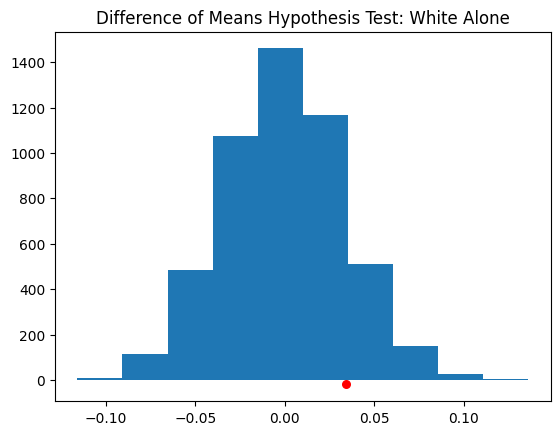

In [129]:
zeros2 = ctmpercent0['Percent: White Alone']
ones2 = ctmpercent1['Percent: White Alone']
zeros2 = zeros2.dropna()
ones2= ones2.dropna()
print([len(zeros2), len(ones2)])

shuffled_combine2 = np.random.permutation(np.append(zeros2, ones2))
shuffled_02 = shuffled_combine2[0:145]
shuffled_12 = shuffled_combine2[145:(145 + 160)]

print(np.mean(shuffled_02) - np.mean(shuffled_12))
test_stat2 = np.mean(ones2) - np.mean(zeros2)
print('test stat is:',round(test_stat2, 2))

differences2 = np.array([])

for i in np.arange(5000):
    shuffled_combine2 = np.random.permutation(np.append(zeros2, ones2))
    shuffled_02 = shuffled_combine2[0:145]
    shuffled_12 = shuffled_combine2[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences2 = np.append(differences2, np.mean(shuffled_12) - np.mean(shuffled_02) )

plt.hist(differences2)
plt.title("Difference of Means Hypothesis Test: White Alone")
plt.scatter(test_stat2, -20, color='red', s=30);

print('test stat is:',round(test_stat2, 2))
sum(differences2 >= test_stat2)/5000

[145, 160]
-0.007136452166053686
test stat is: -0.03


0.7562

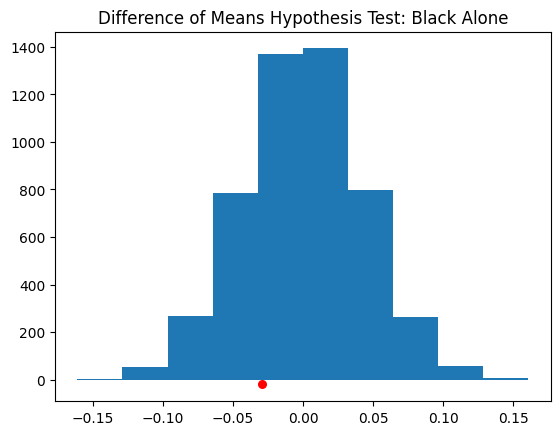

In [131]:
zeros3 = ctmpercent0['Percent: Black or African American Alone']
ones3 = ctmpercent1['Percent: Black or African American Alone']
zeros3 = zeros3.dropna()
ones3= ones3.dropna()
print([len(zeros3), len(ones3)])

shuffled_combine3 = np.random.permutation(np.append(zeros3, ones3))
shuffled_03 = shuffled_combine3[0:145]
shuffled_13 = shuffled_combine3[145:(145 + 160)]

print(np.mean(shuffled_03) - np.mean(shuffled_13))
test_stat3 = np.mean(ones3) - np.mean(zeros3)

differences3 = np.array([])

for i in np.arange(5000):
    shuffled_combine3 = np.random.permutation(np.append(zeros3, ones3))
    shuffled_03 = shuffled_combine3[0:145]
    shuffled_13 = shuffled_combine3[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences3 = np.append(differences3, np.mean(shuffled_13) - np.mean(shuffled_03) )

plt.hist(differences3)
plt.title("Difference of Means Hypothesis Test: Black Alone")
plt.scatter(test_stat3, -20, color='red', s=30);

print('test stat is:',round(test_stat3, 2))
sum(differences3 >= test_stat3)/5000

[145, 160]
-0.00341910997759335
0.03
test stat is: 0.03


0.0004

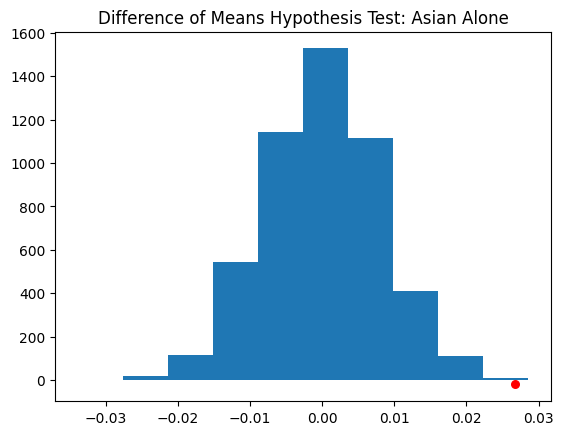

In [132]:
zeros4 = ctmpercent0['Percent: Asian Alone']
ones4 = ctmpercent1['Percent: Asian Alone']
zeros4 = zeros4.dropna()
ones4= ones4.dropna()
print([len(zeros4), len(ones4)])

shuffled_combine4 = np.random.permutation(np.append(zeros4, ones4))
shuffled_04 = shuffled_combine4[0:145]
shuffled_14 = shuffled_combine4[145:(145 + 160)]

print(np.mean(shuffled_04) - np.mean(shuffled_14))
test_stat4 = np.mean(ones4) - np.mean(zeros4)
print(round(test_stat4, 2))

differences4= np.array([])

for i in np.arange(5000):
    shuffled_combine4 = np.random.permutation(np.append(zeros4, ones4))
    shuffled_04 = shuffled_combine4[0:145]
    shuffled_14 = shuffled_combine4[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences4 = np.append(differences4, np.mean(shuffled_14) - np.mean(shuffled_04) )
plt.hist(differences4)
plt.title("Difference of Means Hypothesis Test: Asian Alone")
plt.scatter(test_stat4, -20, color='red', s=30);

print('test stat is:',round(test_stat4, 2))
sum(differences4 >= test_stat4)/5000

[145, 160]
-0.014669290604197624
-0.03
test stat is: -0.03


0.0228

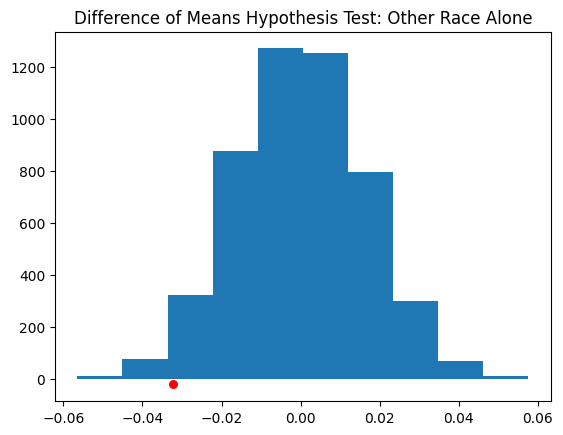

In [137]:
zeros5 = ctmpercent0['Percent: Some Other Race Alone']
ones5 = ctmpercent1['Percent: Some Other Race Alone']
zeros5 = zeros5.dropna()
ones5= ones5.dropna()
print([len(zeros5), len(ones5)])

shuffled_combine5 = np.random.permutation(np.append(zeros5, ones5))
shuffled_05 = shuffled_combine5[0:145]
shuffled_15 = shuffled_combine5[145:(145 + 160)]

print(np.mean(shuffled_05) - np.mean(shuffled_15))
test_stat5 = np.mean(ones5) - np.mean(zeros5)
print(round(test_stat5, 2))

differences5= np.array([])

for i in np.arange(5000):
    shuffled_combine5 = np.random.permutation(np.append(zeros5, ones5))
    shuffled_05 = shuffled_combine5[0:145]
    shuffled_15 = shuffled_combine5[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences5 = np.append(differences5, np.mean(shuffled_15) - np.mean(shuffled_05) )
plt.hist(differences5)
plt.title("Difference of Means Hypothesis Test: Other Race Alone")
plt.scatter(test_stat5, -20, color='red', s=30);

print('test stat is:',round(test_stat5, 2))
sum(differences5 <= test_stat5)/5000

[145, 160]
-0.02409419103472038
-0.06
test stat is: -0.06


0.0632

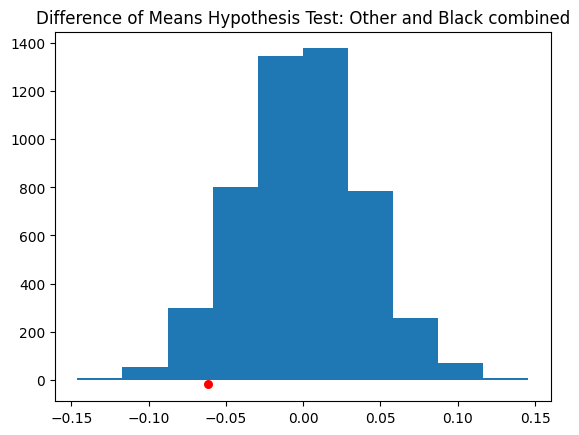

In [136]:
zeros6 = ctmpercent0['Percent: Some Other Race Alone'] + ctmpercent0['Percent: Black or African American Alone']
ones6 = ctmpercent1['Percent: Some Other Race Alone'] + ctmpercent1['Percent: Black or African American Alone']
zeros6 = zeros6.dropna()
ones6= ones6.dropna()
print([len(zeros6), len(ones6)])

shuffled_combine6 = np.random.permutation(np.append(zeros6, ones6))
shuffled_06 = shuffled_combine6[0:145]
shuffled_16 = shuffled_combine6[145:(145 + 160)]

print(np.mean(shuffled_06) - np.mean(shuffled_16))
test_stat6 = np.mean(ones6) - np.mean(zeros6)
print(round(test_stat6, 2))

differences6= np.array([])

for i in np.arange(5000):
    shuffled_combine6 = np.random.permutation(np.append(zeros6, ones6))
    shuffled_06 = shuffled_combine6[0:145]
    shuffled_16 = shuffled_combine6[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences6 = np.append(differences6, np.mean(shuffled_16) - np.mean(shuffled_06) )
plt.hist(differences6)
plt.title("Difference of Means Hypothesis Test: Other and Black combined")
plt.scatter(test_stat6, -20, color='red', s=30);

print('test stat is:',round(test_stat6, 2))
sum(differences6 <= test_stat6)/5000

[145, 160]
-0.013138857416987837
this is the test stat:  0.06
test stat is: 0.06


0.0542

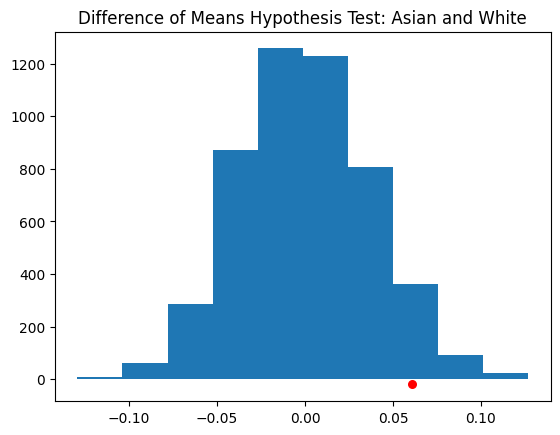

In [135]:
zeros7 = ctmpercent0['Percent: White Alone'] + ctmpercent0['Percent: Asian Alone']
ones7= ctmpercent1['Percent: White Alone'] + ctmpercent1['Percent: Asian Alone']
zeros7 = zeros7.dropna()
ones7= ones7.dropna()
print([len(zeros7), len(ones7)])

shuffled_combine7 = np.random.permutation(np.append(zeros7, ones7))
shuffled_07 = shuffled_combine7[0:145]
shuffled_17 = shuffled_combine7[145:(145 + 160)]

print(np.mean(shuffled_07) - np.mean(shuffled_17))
test_stat7 = np.mean(ones7) - np.mean(zeros7)
print('this is the test stat: ',round(test_stat7, 2))

differences7= np.array([])

for i in np.arange(5000):
    shuffled_combine7 = np.random.permutation(np.append(zeros7, ones7))
    shuffled_07 = shuffled_combine7[0:145]
    shuffled_17 = shuffled_combine7[145:(145 + 160)]
    #np.mean(shuffled_0) - np.mean(shuffled_1) 
    differences7 = np.append(differences7, np.mean(shuffled_17) - np.mean(shuffled_07) )
plt.hist(differences7)
plt.title("Difference of Means Hypothesis Test: Asian and White")
plt.scatter(test_stat7, -20, color='red', s=30);

print('test stat is:',round(test_stat7, 2))
sum(differences7 >= test_stat7)/5000